# 학업탄력성 영향요인 연구
@author: sjh

#!# Todo
- 학업성취 분포 표 수정: seaborn theme, make available comparison
- pythonic replication

## 1. Load

In [1]:
import os
import copy
import json
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from sys import platform

import warnings
warnings.filterwarnings('ignore')

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.autolayout"] = True

# 설치된 폰트 출력
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'Malgun Gothic'

import seaborn as sns
sns.set_style("darkgrid")


BASE_DIR = os.getcwd()
print('>> Current OS: ', platform)
print('>> Current WD: ', BASE_DIR)

>> Current OS:  win32
>> Current WD:  c:\Users\jhun1\Proj\Research\MixedRF


In [3]:
class Load:
    def __init__(self, stuFolder, schFolder, tchFolder, codeBook,
                onlyCodeBook, ):
        if 'darwin' in platform:
            self.BASE_DIR = '/Users/huni/Dropbox/[3]Project/[혼합효과 랜덤포레스트_2022]'
        else:
            if os.getlogin() == 'jhun1':
                self.BASE_DIR = r'C:\Users\jhun1\Dropbox\[3]Project\[혼합효과 랜덤포레스트_2022]'
                
            elif os.getlogin() == 'snukh':
                self.BASE_DIR = r'C:\Users\snukh\Downloads\[혼합효과 랜덤포레스트_2022]' 
        rawData_Folder = 'PISA2018'
        codebook_Folder = 'drive-download-20220816T053902Z-001'

        if onlyCodeBook == False:
            print('>>>>> Init: load raw data')
            stuFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, rawData_Folder, stuFolder)) if FILE[-4:] == '.sav'][0]
            schFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, rawData_Folder, schFolder)) if FILE[-4:] == '.sav'][0]
            tchFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, rawData_Folder, tchFolder)) if FILE[-4:] == '.sav'][0]

            self.rawStu = pd.read_spss(os.path.join(self.BASE_DIR, rawData_Folder, stuFolder, stuFile))
            self.rawSCH = pd.read_spss(os.path.join(self.BASE_DIR, rawData_Folder, schFolder, schFile))
            self.rawTCH = pd.read_spss(os.path.join(self.BASE_DIR, rawData_Folder, tchFolder, tchFile))
            self.dataLS = [self.rawStu, self.rawSCH, self.rawTCH]

            # desciptive
            print('>> Stu data set', self.rawStu.shape)
            print('>> Sch data set', self.rawSCH.shape)
            print('>> Tch data set', self.rawTCH.shape)
        
        else:
            print('>> Only Codebook will be loaded')
            pass
        
        self.cb = pd.read_excel(os.path.join(self.BASE_DIR, codebook_Folder, codeBook), sheet_name='변수선택(1213)')



    def defaultCleaner(self):
        print('\n\n>>>> Cleaning: default nation and variable')


        ### dictionary by nation
        def cleaningNational(dataLS, SouthKorea = 'Korea', US='United States'):
            nationalData = {'SK': [], 'US': []}

            for nation_name, code in zip(nationalData.keys(), [SouthKorea, US]):
                print(f'\n>> slicing: {nation_name}')
                for data in dataLS:
                    # print(data.head(5))
                    temp2 = data[data['CNTRYID'] == code]
                
                    nationalData[nation_name].append(temp2)
                    print('>> sliced shape: ', temp2.shape)
            
            return nationalData
            

        def cleaningVariable(data, codeBook):
            output = {}
            
            for nation_name in data.keys():
                Column_toSave = {'Stu': [], 'Sch': [], 'Tch': []}
                for fileName, variable, category in tqdm(zip(codeBook['file name'].values, codeBook['NAME'].values, codeBook['categories']), desc=">> variable check"):
                    # 코드북 내에서도 분석에서 제할 변수는 file name을 비움
                    if type(fileName) != str:
                        continue


                    else: 
                        if category == 'identifier':
                            Column_toSave['Stu'].append(variable)
                            
                            if variable == 'CNTSTUID':
                                continue
                            else: # 코드북 구조 문제: 학교, 교사 셋에는 해당 변수가 없어서 추가해줌
                                Column_toSave['Sch'].append(variable)
                                Column_toSave['Tch'].append(variable)

                        else:
                            if 'STU' in fileName:
                                if variable in data[nation_name][0].columns:
                                    Column_toSave['Stu'].append(variable)
                                else:
                                    print('>> none(stu)', variable)

                            elif 'SCH' in fileName:
                                if variable in data[nation_name][1].columns:
                                    Column_toSave['Sch'].append(variable)
                                else:
                                    print('>> none(sch)', variable)

                            elif 'TCH' in fileName:
                                if variable in data[nation_name][2].columns:
                                    Column_toSave['Tch'].append(variable)
                                else:
                                    print('>> none(tch)', variable)
                    
                
                # print('>>>> save: ', Column_toSave)
                output[nation_name] = [data[nation_name][0][Column_toSave['Stu']],
                                        data[nation_name][1][Column_toSave['Sch']],
                                        data[nation_name][2][Column_toSave['Tch']],
                                        ]
                assert len(Column_toSave['Tch']) < 4, print(Column_toSave['Tch'])

            assert 'SK' in output.keys()
            assert 'US' in output.keys()
            return output

        cleaned_Nation = cleaningNational(dataLS = self.dataLS)
        self.default_cleaningData = cleaningVariable(data = cleaned_Nation, codeBook = self.cb)

        # categories 에서 일단은 codebook에 있는 변수가 다 있나 확인
        # categories 에서 individual & family, school 구분

In [4]:
LOAD_ONLY_CODEBOOK = True

Loader = Load(stuFolder="STU", schFolder='SCH', tchFolder='TCH',
                onlyCodeBook = LOAD_ONLY_CODEBOOK,
                codeBook='PISA2018_CODEBOOK (변수선택-공유).xlsx'
                )

if LOAD_ONLY_CODEBOOK == False:
    Loader.defaultCleaner()
    print(Loader.default_cleaningData.keys())

    with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(SK).xlsx')) as writer:
        Loader.default_cleaningData['SK'][0].to_excel(writer, sheet_name='stu', index=False)
        Loader.default_cleaningData['SK'][1].to_excel(writer, sheet_name='sch', index=False)
        Loader.default_cleaningData['SK'][2].to_excel(writer, sheet_name='tch', index=False) 


    with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(US).xlsx')) as writer:
        Loader.default_cleaningData['US'][0].to_excel(writer, sheet_name='stu', index=False)
        Loader.default_cleaningData['US'][1].to_excel(writer, sheet_name='sch', index=False)
        Loader.default_cleaningData['US'][2].to_excel(writer, sheet_name='tch', index=False)

>> Only Codebook will be loaded


minor thing, for replicate hong kong paper

In [4]:
# ls_hk = []
# for data in Loader.dataLS:
#     df = data[data['CNTRYID'] == 'Hong Kong']
#     ls_hk.append(df)
#     print('>> ', df.shape) 

In [5]:
# with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'rawData(HK).xlsx')) as writer:
#     ls_hk[0].to_excel(writer, sheet_name='stu', index=False)
#     ls_hk[1].to_excel(writer, sheet_name='sch', index=False)
#     ls_hk[2].to_excel(writer, sheet_name='tch', index=False)

## 2. Preprocessing

In [5]:
# 앞선 처리 데이터 불러오기
loadedData = {'SK': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='tch'),
            
            ],
        'US': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='tch'),
            ]}

In [6]:
class Preprocessing:
    def __init__(self, LoadedData, codeBook, dummyCodeBook):
        self.data = LoadedData
        self.cb = codeBook
        with open(dummyCodeBook, encoding='utf-8') as json_file:
            self.dummyCB = json.load(json_file)
        self.testBook = {
                    'read/math/sci_1': 'PV1MATH PV1READ PV1SCIE'.split(),
                    'read/math_1': 'PV1MATH PV1READ'.split(),
                    'read/math_10': 'PV1MATH PV2MATH PV3MATH PV4MATH PV5MATH PV6MATH PV7MATH PV8MATH PV9MATH PV10MATH PV1READ PV2READ PV3READ PV4READ PV5READ PV6READ PV7READ PV8READ PV9READ PV10READ'.split(),
                    'read_1': ['PV1READ'],
                    'read_10': 'PV1READ PV2READ PV3READ PV4READ PV5READ PV6READ PV7READ PV8READ PV9READ PV10READ'.split()
                }
        self.nation_real_name = {'SK': '대한민국', 'US': '미국'} 

        self.valid_data = {}
        self._1_dummy = {}
        self._2_joined = {}
        self._3_dropNa = {}
        self._4_ESCS = {'full': {}, 'sliced': {}} # 여기서 데이터 갈라야함
        self._5_shouldBeCal = {}
        self.finalRS = {}
        
        self.rs_1_columnFull = pd.DataFrame()
        self.rs_1_columnSK = pd.DataFrame()
        self.rs_1_columnUS = pd.DataFrame()
        

    ### Needs1. is selected variable contained in both dataset
    def noDataColumn(self): # 열별로 계산
        toDrop = {}
        
        for nationName, nationalData in self.data.items():
            print('>> test NA column: ', nationName)

            toDrop[nationName] = []
            for idx, (label, inputDf) in enumerate(zip('stu sch tch'.split(), nationalData)):
                if label == 'tch':
                    continue
                else:
                    print(label)
                    for column in inputDf.columns:
                        if inputDf[column].isna().sum() > (inputDf.shape[0] * 0.8):
                            print('>>> over 80% is NA: ', column)
                            toDrop[nationName].append(column)
                        
                        elif 'missing' in inputDf[column].values:
                            print('>>> missing: ', column)
                            toDrop[nationName].append(column)
                        
                        else:
                            continue
        if (len(toDrop['SK']) ==0) and (len(toDrop['US']) ==0):
            self.valid_data = self.data
        else:
            raise ValueError("NaN column exist, check for this")
        return toDrop
            # assert len(toDrop[nationName]) == 2, print(toDrop)


    def Dummy(self, doDummy):
        # match key and value from codeBook
        print('\n\n>>>> 1. Dummy coding')
        def matchKV(codeBookDict, inputList):
            outputLS = []
            for val in inputList:
                try:
                    outputLS.append(codeBookDict[val])
                except KeyError:
                    outputLS.append(np.nan)
            
            return outputLS
        
        if doDummy == True:
            notDummyCol1 = self.cb[self.cb['categories'] == 'identifier'].index
            notDummyCol2 = self.cb[self.cb['categories'] == 'resilient status'].index
            notDummyCol3 = self.cb[self.cb['file name'] == 'should be caculated'].index
            
            toDummy = self.cb.drop(list(notDummyCol1)+list(notDummyCol2)+list(notDummyCol3), axis=0) # 더미 변환 안할 변수 행 삭제함
            # display(toDummy)

            for nationalName, inputNational in self.valid_data.items():
                outputNational = copy.deepcopy(inputNational)

                for idx, row in toDummy.iterrows(): # 변수별로 반복문
                    variable = row['NAME']
                    
                    if type(row['file name']) != str: # 분석에서 제외할 변수가 있어서 버림
                        continue

                    else:
                        if ('STU' in row['file name']) and (variable in self.dummyCB['stu']):
                            outputLS = matchKV(self.dummyCB['stu'][variable], outputNational[0][variable])
                            outputNational[0][variable] = outputLS 

                    # 학교, 교사 데이터는 더미코딩할 것 없음
                self._1_dummy[nationalName] = outputNational
        elif doDummy == False:
            self._1_dummy = copy.deepcopy(self.valid_data)
        else:
            raise TypeError('>> Error: check option Type')


    def Join(self):
        print('\n\n>>>> 2. Join DataFrame')

        for nationalName, inputNational in self._1_dummy.items():
            print('>> join nation: ', nationalName)
            inputNational[0].reset_index(drop=True, inplace=True)
            
            outputDf = copy.deepcopy(inputNational[0])
            # print('>> before ', outputDf.shape)
            before = outputDf.shape


            inputNational[1].drop(['CNTRYID', 'CNT'], axis=1, inplace=True)
            if inputNational[1].index.name == 'CNTSCHID':
                pass
            else:
                inputNational[1].set_index('CNTSCHID', drop=True, inplace=True)
            
            if inputNational[1].shape[1] == 0:
                print('>> school data is empty')
                pass
            else:
                for idx, row in tqdm(outputDf.iterrows(), desc=">> mapping"):
                    toBeInput = inputNational[1].loc[row['CNTSCHID']].values # 학생 데이터에 들어가야할 학교 데이터 찾기
                    assert len(toBeInput) == inputNational[1].shape[1]
                    
                    toBeInput_T = toBeInput.reshape(1, 8)
                    outputDf.loc[idx, list(inputNational[1].columns)] = toBeInput_T[0]
            
                after = outputDf.shape
                print('>>>> Bef: ', before, '....', 'Aft: ', after)
                assert 'EDUSHORT' in outputDf.columns

            self._2_joined[nationalName] = outputDf

    def DropStudent(self):
        # 각 column 별로 데이터 검수
        print('\n\n>>>> 3. Verify na and Drop student')
        print(self._2_joined.keys())
        def column_wise(inputData):
            if type(inputData) == dict:
                merged = pd.concat([inputData['SK'], inputData['US']])
                assert merged.shape[0] == inputData['SK'].shape[0] + inputData['US'].shape[0]
            elif type(inputData) == pd.DataFrame:
                merged = copy.deepcopy(inputData)
            
            else:
                raise TypeError('>> Error: Check your input D type')
                

            describeDF = merged.describe().T
            describeDF['NA_ratio'] = round(
                100 - describeDF['count']/merged.shape[0]*100,
                 2
                 )

            newColumnOrder = [describeDF.columns[0], 'NA_ratio'] + list(describeDF.columns[1:-1])
            describeDF= describeDF[newColumnOrder]
            return describeDF

        # 각 학생별로 데이터 검수
        def row_wise(inputData):
            merged = pd.concat([inputData['SK'], inputData['US']])
            assert merged.shape[0] == inputData['SK'].shape[0] + inputData['US'].shape[0]
            # unlike column wise, we prepare data with 

            for_histogram = {}
            for label, data in zip(['full', 'SK', 'US'], [merged, inputData['SK'], inputData['US']]):
                for_histogram[label] = []

                for i in range(len(data.index)) :
                    na_ratio = round((data.iloc[i].isnull().sum()/data.shape[1]) * 100, 0)
                    for_histogram[label].append(na_ratio)

            fig = plt.figure(figsize=(17,6))

            plt.subplot(1, 3, 1)
            plt.hist(for_histogram['full'])
            plt.title('\n전체 데이터\n')
            plt.xlabel('\n전체 변수 대비 결측비율(%)\n')
            plt.ylabel('빈도')
            
            plt.subplot(1, 3, 2)
            plt.hist(for_histogram['SK'])
            plt.title('\nSouth Korea\n')
            plt.xlabel('\n전체 변수 대비 결측비율(%)\n')
            plt.ylabel('빈도')
            
            plt.subplot(1, 3, 3)
            plt.hist(for_histogram['US'])
            plt.title('\nUnited States\n')
            plt.xlabel('\n전체 변수 대비 결측비율(%)\n')
            plt.ylabel('빈도')

            plt.savefig(os.path.join(BASE_DIR, 'data', f'NA_ratio.jpg'))
            plt.show()

            return for_histogram
        
        def dropOver(inputData, rowWiseResult):
            assert type(rowWiseResult) == list
            output = copy.deepcopy(inputData)

            toDrop = []
            for idx, sumNA in zip(output.index, rowWiseResult):
                if sumNA > 30:
                    toDrop.append(idx)
            
            before = output.shape[0]
            output.drop(toDrop, axis=0, inplace=True)
            after = output.shape[0]
            print('>> NA drop: ', before - after)

            return output
        
        self.rs_1_columnFull = column_wise(self._2_joined)
        self.rs_1_columnSK = column_wise(self._2_joined['SK'])
        self.rs_1_columnUS = column_wise(self._2_joined['US'])

        rowWiseNA = row_wise(self._2_joined)
        self._3_dropNa['SK'] = dropOver(self._2_joined['SK'], rowWiseResult=rowWiseNA['SK'])
        self._3_dropNa['US'] = dropOver(self._2_joined['US'], rowWiseResult=rowWiseNA['US'])
        
        
    def ESCS(self, score_calculating_method, column_to_analysis, *slicing_args):
        # 데이터를 두개 만들어야함, result, resultSlice
        # '''
        # 1. score_calculating_method:
        # 'mean' : mean of variables more than 1
        # 'level': cutting manually decided score
        # arg1. test_key : if 'score_calculating_method'
        # arg2. Threshold_Reading_Score : score value
        # '''
        print('\n\n>>>> 4. Slicing data by ESCS')
        
        def thresholdCalculator(inputData,
                                score_calculating_method,
                                column_to_analysis, 
                                academic_slicing_info):
            
            threshold = {'SK': {}, 'US': {}}

            for nationalName, inputNational in inputData.items():
                # cal academic score
                targetColumn = self.testBook[column_to_analysis]
                inputNational['AcademicScore'] = inputNational.loc[:, targetColumn].mean(axis=1)
                
                if score_calculating_method == 'mean':
                    threshold[nationalName]['academic_score'] = inputNational['AcademicScore'].quantile(0.75)
                elif score_calculating_method == 'level':
                    assert type(academic_slicing_info) == int, print('Insert validate type args : ', academic_slicing_info)
                    threshold[nationalName]['academic_score'] = academic_slicing_info 
                else:
                    raise ValueError("Specify right method")
                
                # cal escs score
                threshold[nationalName]['escs_score'] = inputNational['ESCS'].quantile(0.25)

            return threshold, inputData # 새로운 열이 추가되었으므로 리턴해서 사용해야함
        
        def escsSlice(inputDict, escsThreshold):
            assert type(inputDict) == dict, print('>> Error: must input Dict')
            assert type(escsThreshold) == dict
            output = {'SK': pd.DataFrame(), 'US': pd.DataFrame()}
            for nationalName, inputNational in inputDict.items():
                
                before = inputNational.shape[0]
                toDrop = []
                for idx, val in zip(inputNational['ESCS'].index, inputNational['ESCS'].values):
                    if val < escsThreshold[nationalName]['escs_score']:
                        continue
                    else:
                        toDrop.append(idx) # escs 하위 25%를 넘는 친구들은 버림
                
                
                output[nationalName] = inputNational.drop(toDrop, axis=0)
                after = output[nationalName].shape[0]
                print('>> before: ', before, '>> after: ', after)
            
            return output


        def quantileCalculator( 
                            inputData, # 전체 Full, escs 하위 25%로 데이터셋이 2개로 나뉘므로 인풋을 줘야함
                            option, # full: 전체 데이터, sliced: 잘린 데이터
                            AcademicThreshold
                            ):
            
            assert type(AcademicThreshold) == dict
            print('\n>> Option: ', option)

            output = {'SK': pd.DataFrame(), 'US': pd.DataFrame()}
            for IDX, (nationalName, inputNational) in enumerate(inputData.items()):
                total = inputNational.shape[0]
                
                iamResilient = []
                if option == 'full':
                    escsVar = inputNational['ESCS'].quantile(0.25) # 하위 25%
                    for idx, row in inputNational.iterrows():
                        if row['AcademicScore'] > AcademicThreshold[nationalName]['academic_score'] and row['ESCS'] < AcademicThreshold[nationalName]['escs_score']: # sliced 데이터에서는 이 기준을 만족할 수 없음
                            iamResilient.append(1)
                        else:
                            iamResilient.append(0)

                elif option == 'sliced':
                    for idx, row in inputNational.iterrows():
                        if row['AcademicScore'] > AcademicThreshold[nationalName]['academic_score']: # sliced 데이터는 escs 기준 필요 없음
                            iamResilient.append(1)
                        else:
                            iamResilient.append(0)

                inputNational['resilient'] = iamResilient
                resilientCount = [x for x in iamResilient if x ==1]
                print(f'>> 회복탄력성 학생수({nationalName}): ', len(resilientCount), f'({round(len(resilientCount)/total*100, 2)})%')

                output[nationalName] = inputNational

            return output

        def visualize(inputData,
                    option, # full: 전체 데이터, sliced: 잘린 데이터
                    figName, # 그림 제목
                    AcademicThreshold
                        ):

            fig = plt.figure(figsize=(17,9))
            for IDX, (nationalName, inputNational) in enumerate(inputData.items()):

                plt.subplot(2, 2, 2*IDX+1)
                plt.hist(inputNational['AcademicScore'])
                plt.title(f'\n학업성취{self.nation_real_name[nationalName]}\n')
                plt.xlabel('\n점수\n')
                plt.axvline(AcademicThreshold[nationalName]['academic_score'], color='r', linewidth=1, linestyle='--')
                
                plt.subplot(2, 2, 2*IDX+2)
                plt.hist(inputNational['ESCS'])
                plt.title(f'\n사회문화경제{self.nation_real_name[nationalName]}\n')
                plt.xlabel('\n점수\n')
                if option=='full':
                    plt.axvline(AcademicThreshold[nationalName]['escs_score'], color='r', linewidth=1, linestyle='--')

                
            plt.savefig(os.path.join(BASE_DIR, 'data', f'{figName}_{option}.jpg'))
            plt.show()
        
        ## 1. calculate threshold value
        AcademicThreshold, newData_dict = thresholdCalculator(self._3_dropNa,
                                                            score_calculating_method = score_calculating_method,
                                                            column_to_analysis = column_to_analysis,
                                                            academic_slicing_info=slicing_args[0]) ## 학업성취 코딩 방법을 바꿀 때 여기 arg를 조정
        print(f">> 학문성취 상위 75%: 우리나라.. {AcademicThreshold['SK']['academic_score']}, 미국.. {AcademicThreshold['US']['academic_score']}")
        
        
        ## 2. slice
        self._4_ESCS['full'] = copy.deepcopy(newData_dict) # no drop case, so just copied
        self._4_ESCS['sliced'] = escsSlice(newData_dict, escsThreshold = AcademicThreshold)
        assert type(self._4_ESCS['full']) == dict, print(self._4_ESCS['full'])


        ## 3. labeling resilient student
        self._4_ESCS['full'] = quantileCalculator(inputData=self._4_ESCS['full'], 
                                                option = 'full',
                                                AcademicThreshold= AcademicThreshold)
        self._4_ESCS['sliced'] = quantileCalculator(inputData=self._4_ESCS['sliced'], 
                                                option = 'sliced',
                                                AcademicThreshold= AcademicThreshold)

        ## 4. visualize resilient student
        visualize(self._4_ESCS['full'], option='full', figName='읽10', AcademicThreshold= AcademicThreshold)
        visualize(self._4_ESCS['sliced'], option = 'sliced', figName ='읽10(target paper)', AcademicThreshold= AcademicThreshold)

    
    # should be calculated 변수들 계산하는 것임
    def shouldBeCalculated(self):
        print('\n\n>>>> 6. Should Be Calculated')
        
        def schoolMean(inputDf, whichVar):
            assert type(whichVar) == list
            outputMean = {}
            for sch_id in inputDf['CNTSCHID'].values:
                # print('>> ', sch_id)
                if sch_id in outputMean.keys():
                    continue
                
                else:
                    temp1 = inputDf[inputDf['CNTSCHID'] == sch_id]
                    temp2 = temp1.loc[:, whichVar] 
                    assert len(temp2.columns) == len(whichVar)
                    meanVal = np.nanmean(temp2.values)
                    assert type(meanVal) == np.float64, print('Error : ', type(meanVal))

                    outputMean[sch_id] = meanVal
            
            return outputMean
        
        
        def meanMapping(inputColumn, mean_dict):
            outputLS = []
            for idx, sch_id in enumerate(inputColumn.values):
                outputLS.append(mean_dict[sch_id])

            return outputLS
        

        def matching(inputData, codeBook):
            output = copy.deepcopy(inputData)
            shouldBeCal = self.cb[self.cb['file name'] == 'should be caculated']
            assert len(shouldBeCal) == 2, print('Error: check self.cb')
            for national in output.keys():
                beforeShape = output[national].shape[1]
                
                calVal = list(codeBook[codeBook['categories'] == 'resilient status']['NAME'])
                calVal.remove('ESCS')
                
                for variable in shouldBeCal['NAME'].values:
                
                    if variable == 'AVG_S_TEST':    
                        mean_dict = schoolMean(output[national], calVal)
                        
                    elif variable == 'AVG_S_ESCS':
                        mean_dict = schoolMean(output[national], ['ESCS'])

                    #평균 dict 활용해서 매칭 진행
                    outputLS = meanMapping(output[national]['CNTSCHID'], mean_dict)
                    assert len(outputLS) == output[national].shape[0], print('Error: ', len(outputLS))
                    output[national][variable] = outputLS # 학교 데이터이므로, 학교에 맞춰서 추가하기

                afterShape = output[national].shape[1]
                assert afterShape - beforeShape == 2, print('Beofre: ', beforeShape, ' ... ', 'After: ', afterShape)
            
            return output
        
        if 'should be calculated' in self.cb['file name'].values:
            self._5_shouldBeCal['full'] = matching(self._4_ESCS['full'], codeBook = self.cb)
            self._5_shouldBeCal['sliced'] = matching(self._4_ESCS['sliced'], codeBook = self.cb)
        else:
            self._5_shouldBeCal['full'] = copy.deepcopy(self._4_ESCS['full'])
            self._5_shouldBeCal['sliced'] = copy.deepcopy(self._4_ESCS['sliced'])
            

    
    def AdjustMinor(self):
    # ```
    # 마이너한 것들을 조정하기 위함
    # ```
        print('\n\n>>>> 7. Manually adjust')
        # 두 데이터를 나라 row를 만들고, 합치기 위함
        def Merge(inputData):
            output = pd.concat([inputData['SK'], inputData['US']], axis=0)
            assert inputData['SK'].shape[0] + inputData['US'].shape[0] == output.shape[0]

            dropAcademic = ['CNTRYID', 'AcademicScore']
            for column in output.columns:
                if 'PV' in column:
                    dropAcademic.append(column)

            output.drop(dropAcademic, axis=1, inplace=True)
            # print('>> columns: ', output.columns)
            return output

        # spss 편하도록, 주요 변수들을 앞으로 빼는 작업
        def columnOrder(inputData,
                        important_columns=['resilient']):
            column_ID = ['CNT', 'CNTSCHID', 'CNTSTUID']

            inputData.set_index(column_ID+important_columns, inplace=True)
            inputData.reset_index(inplace=True)

            return inputData

        self.finalRS['full'] = Merge(self._5_shouldBeCal['full'])
        self.finalRS['sliced'] = Merge(self._5_shouldBeCal['sliced'])

        self.finalRS['full'] = columnOrder(self.finalRS['full'])
        self.finalRS['sliced'] = columnOrder(self.finalRS['sliced'])


processor = Preprocessing(LoadedData=loadedData, codeBook=Loader.cb, dummyCodeBook='dummyCoding.json')
processor.noDataColumn()

>> test NA column:  SK
stu
sch
>> test NA column:  US
stu
>>> over 80% is NA:  PERSPECT
sch


ValueError: NaN column exist, check for this

In [8]:
type(processor.data['SK'])

list

In [7]:
before = processor.data['SK'][0].shape[1]
for nation, groups in processor.data.items():
    processor.valid_data[nation] = []
    for idx, data in enumerate(groups):
        if idx == 0 :
            print('1')
            processor.valid_data[nation].append(data.drop('PERSPECT', axis=1))
        else: 
            processor.valid_data[nation].append(data)

after = processor.valid_data['SK'][0].shape[1]
assert before - after == 1, print(after, before)

1
1




>>>> 1. Dummy coding


>>>> 2. Join DataFrame
>> join nation:  SK
>> school data is empty
>> join nation:  US
>> school data is empty


>>>> 3. Verify na and Drop student
dict_keys(['SK', 'US'])


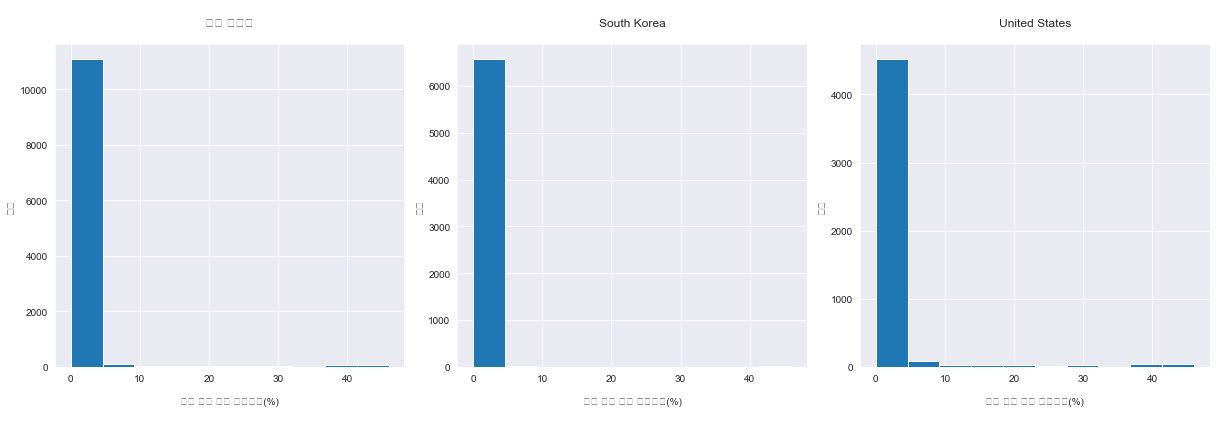

>> NA drop:  28
>> NA drop:  112


>>>> 4. Slicing data by ESCS
>> 학문성취 상위 75%: 우리나라.. 480, 미국.. 480
>> before:  6622 >> after:  1654
>> before:  4726 >> after:  1174

>> Option:  full
>> 회복탄력성 학생수(SK):  860 (12.99)%
>> 회복탄력성 학생수(US):  473 (10.01)%

>> Option:  sliced
>> 회복탄력성 학생수(SK):  860 (52.0)%
>> 회복탄력성 학생수(US):  473 (40.29)%


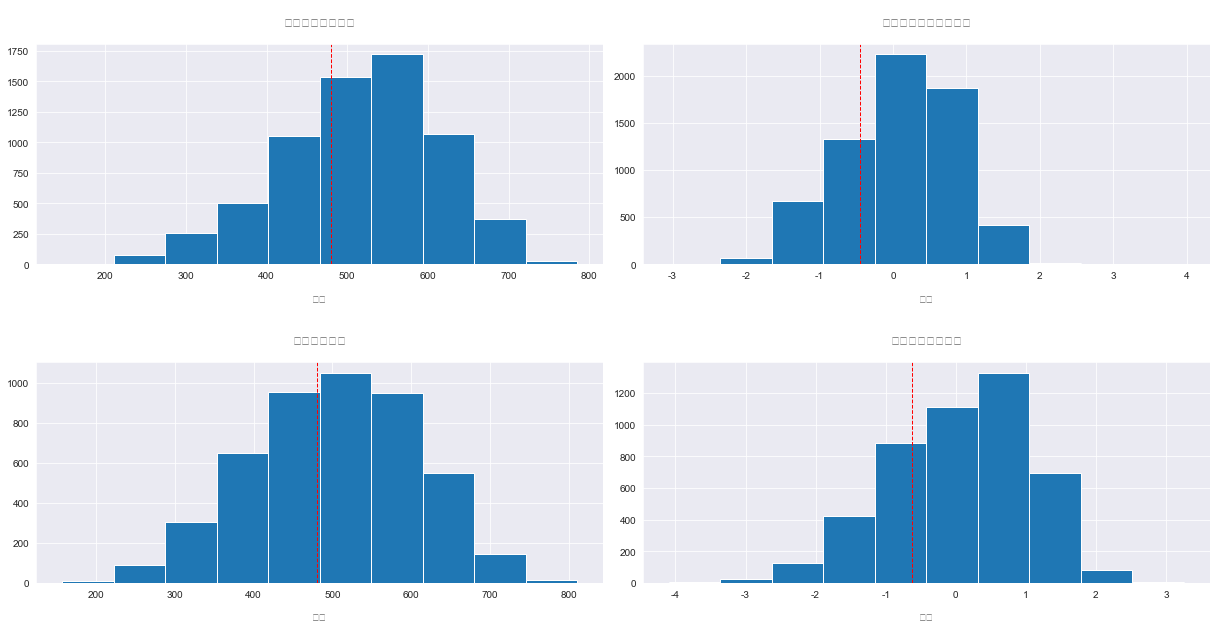

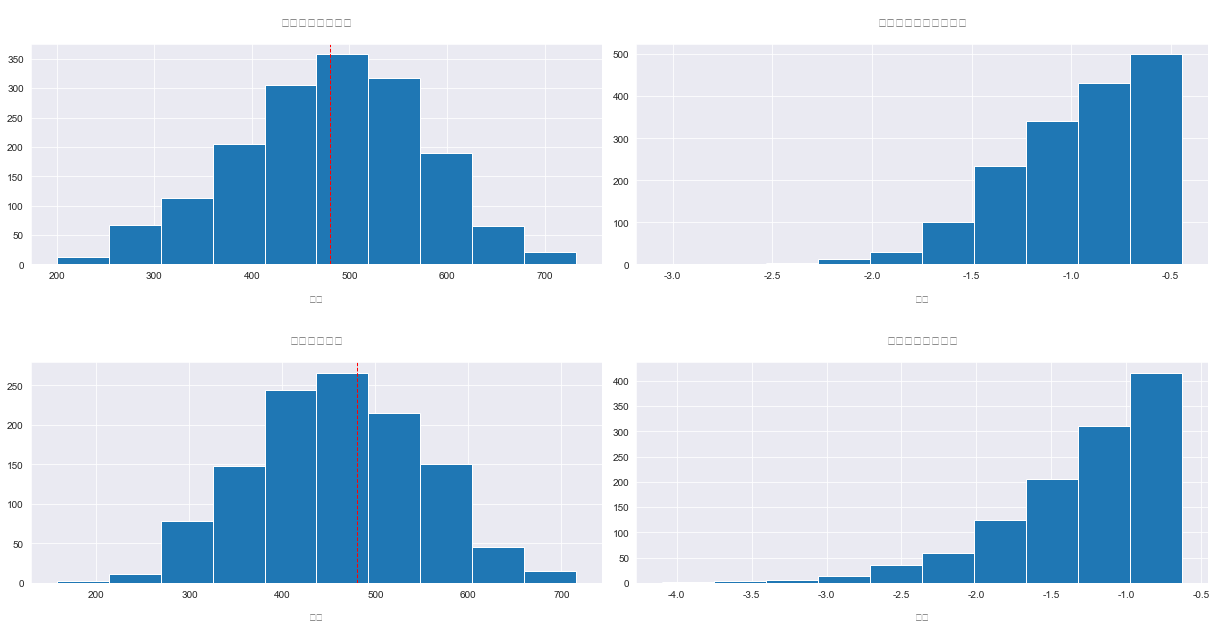



>>>> 6. Should Be Calculated


>>>> 7. Manually adjust


In [8]:
processor.Dummy(doDummy=False) # 굳이 dummy할 필요가 없음, rf에서 categorical / numerical 인식해야함
processor.Join()
processor.DropStudent()
processor.ESCS('level', 'read_10' ,480) # Lv4: 553, Lv3: 480, Lv2: 407
processor.shouldBeCalculated()
processor.AdjustMinor()

In [9]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'preprocessing.xlsx')) as writer:
    processor.finalRS['full'].to_excel(writer, sheet_name='full', index=False)
    processor.finalRS['sliced'].to_excel(writer, sheet_name='sliced', index=False)

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'raw_forValidate.xlsx')) as writer:
    processor._3_dropNa['SK'].to_excel(writer, sheet_name='south korea', index=False)
    processor._3_dropNa['US'].to_excel(writer, sheet_name='us', index=False)
    processor._4_ESCS['sliced']['SK'].to_excel(writer, sheet_name='sliced', index=False)

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'descriptive(raw).xlsx')) as writer:
    processor.rs_1_columnFull.to_excel(writer, sheet_name='dsec_full', index=True)
    processor.rs_1_columnSK.to_excel(writer, sheet_name='dsec_SK', index=True)
    processor.rs_1_columnUS.to_excel(writer, sheet_name='dsec_US', index=True)

In [10]:
df_SK = processor.finalRS['sliced'][processor.finalRS['sliced']['CNT'] == 'Korea']
df_US = processor.finalRS['sliced'][processor.finalRS['sliced']['CNT'] == 'United States']

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'preprocessing(SK_sliced).xlsx')) as writer:
    df_SK.to_excel(writer, sheet_name='sheet1', index=False) # if using other sheet_name causing error sometimes

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'preprocessing(US_sliced).xlsx')) as writer:
    df_US.to_excel(writer, sheet_name='sheet1', index=False) # if using other sheet_name causing error sometimes

## Descriptive Statics

In [26]:
# 앞선 처리 데이터 불러오기
# fullData = pd.read_excel(os.path.join(BASE_DIR, 'data', 'preprocessing.xlsx'), sheet_name='full')
slicedData = pd.read_excel(os.path.join(BASE_DIR, 'data', 'preprocessing.xlsx'), sheet_name='sliced')

In [27]:
class Descriptive:
    def __init__(self, cleanedData):
        self.df = cleanedData
        self.NUM = {'full': pd.DataFrame(),
                    'SK': {'SK': pd.DataFrame(), 'res': pd.DataFrame(), 'nonRes': pd.DataFrame()},
                    'US': {'SK': pd.DataFrame(), 'res': pd.DataFrame(), 'nonRes': pd.DataFrame()}
                    }
        self.CAT = {'full': pd.DataFrame(),
                    'SK': {'SK': pd.DataFrame(), 'res': pd.DataFrame(), 'nonRes': pd.DataFrame()},
                    'US': {'SK': pd.DataFrame(), 'res': pd.DataFrame(), 'nonRes': pd.DataFrame()}
                    }

        self._1_full = pd.DataFrame()
        self._2_SKFull = pd.DataFrame()
        self._2_SKRes = pd.DataFrame()
        self._2_SKnonRes = pd.DataFrame()
        self._3_US = pd.DataFrame()
        self._3_USRes = pd.DataFrame()
        self._3_USnonRes = pd.DataFrame()
        
    def Numeric(self):

        def naRatio(fullCount, inputArr):
            output = 100 - inputArr/fullCount*100
            return np.round(output, decimals=2)

        def Full(inputData):
            output = inputData.describe().T.round(2)
            output['na_ratio'] = naRatio(inputData.shape[0], output['count'])
            return output

        def groupBy(inputData, groupByColumn):
            output= {}
            
            for uniqueVal in inputData[groupByColumn].unique():
                str_uniqueVal = str(uniqueVal) # in case of resilient, type changed
                # print(str_uniqueVal)
                df_slice = inputData[inputData[groupByColumn] == uniqueVal]
                output[str_uniqueVal]= df_slice.describe().T.round(2)
                output[str_uniqueVal]['na_ratio'] = naRatio(df_slice.shape[0], output[str_uniqueVal]['count'])
                
            return output

        self.NUM['full'] = Full(self.df)

        nationDict = groupBy(self.df, groupByColumn='CNT')
        self.NUM['SK']['SK'] = nationDict['Korea']
        self.NUM['US']['US'] = nationDict['United States']

        resilientSK = groupBy(self.df[self.df['CNT'] == 'Korea'], groupByColumn='resilient')
        self.NUM['SK']['res'] = resilientSK['1']
        self.NUM['SK']['nonRes'] = resilientSK['0']
        
        resilientUS = groupBy(self.df[self.df['CNT'] == 'United States'], groupByColumn='resilient')
        self.NUM['US']['res'] = resilientUS['1']
        self.NUM['US']['nonRes'] = resilientUS['0']


    def Categorical(self):

        def sliceCategorical(inputData,
                            referenceNumerical # for assert 
                            ):   
            num_cols = inputData._get_numeric_data().columns
            cat_cols = list(set(inputData.columns) - set(num_cols))
            
            assert list(num_cols) == list(referenceNumerical.index), print(num_cols)

            return cat_cols

        def Full(inputData, cat_cols):
            df_cat = inputData[cat_cols]
            temp = df_cat.describe(include='all').T
            temp['na_ratio'] = temp['freq'].values/temp['count'].values*100
            # temp['na_ratio'] = np.round(temp['na_ratio'], 2) #!# error: infinite
            return temp
            

        def groupBy(inputData, groupByColumn, cat_cols):
            output= {}
            for uniqueVal in inputData[groupByColumn].unique():
                str_uniqueVal = str(uniqueVal) # in case of resilient, type changed
                df_slice = inputData[inputData[groupByColumn] == uniqueVal]
                df_cat = df_slice[cat_cols] # slice
                temp = df_cat.describe(include='all').T
                
                temp['na_ratio'] = 100 - temp['freq'].values/temp['count'].values*100
                # temp['na_ratio'] = np.round(temp['na_ratio'], 2) #!# error: infinite
                output[str_uniqueVal] = temp.round(2)
                
            return output

        
        cat_cols = sliceCategorical(self.df, referenceNumerical=self.NUM['full'])
        self.CAT['full'] = Full(self.df, cat_cols=cat_cols)
        
        nationDict = groupBy(self.df, groupByColumn='CNT', cat_cols=cat_cols)
        self.CAT['SK']['SK'] = nationDict['Korea']
        self.CAT['US']['US'] = nationDict['United States']


        resilientSK = groupBy(self.df[self.df['CNT'] == 'Korea'], groupByColumn='resilient', cat_cols=cat_cols)
        self.CAT['SK']['res'] = resilientSK['1']
        self.CAT['SK']['nonRes'] = resilientSK['0']
        
        resilientUS = groupBy(self.df[self.df['CNT'] == 'United States'], groupByColumn='resilient', cat_cols=cat_cols)
        self.CAT['US']['res'] = resilientUS['1']
        self.CAT['US']['nonRes'] = resilientUS['0']
        
    
    def Join(self):

        def merger(df_num, df_cat):
            output = pd.concat([df_num, df_cat], axis=0) # concate on row
            # for cat_idx in df_cat.index:
            # 합치면 좋겠지만, num, cat 구분 잘되서 좋음

            ## drop unnecessary columns
            output.drop(columns=['min', '25%', '50%', '75%', 'max'], inplace=True)
            output.drop(index=['CNTSCHID', 'CNTSTUID', 'CNT', 'resilient'], inplace=True)

            ## re-order columns 
            output.reset_index(drop=False, inplace=True)
            output.set_index(['index', 'count', 'na_ratio'], inplace=True)
            output.reset_index(drop=False, inplace=True)
            output.set_index('index',inplace=True)
            return output.round(2)
        
        self._1_full = merger(self.NUM['full'], self.CAT['full'])
        self._2_SKFull = merger(self.NUM['SK']['SK'], self.CAT['SK']['SK'])
        self._2_SKRes = merger(self.NUM['SK']['res'], self.CAT['SK']['res'])
        self._2_SKnonRes = merger(self.NUM['SK']['nonRes'], self.CAT['SK']['nonRes'])
        self._3_USFull = merger(self.NUM['US']['US'], self.CAT['US']['US'])
        self._3_USRes = merger(self.NUM['US']['res'], self.CAT['US']['res'])
        self._3_USnonRes = merger(self.NUM['US']['nonRes'], self.CAT['US']['nonRes'])
        
        

analyzer = Descriptive(slicedData)
analyzer.Numeric()
analyzer.Categorical()
analyzer.Join()

In [28]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'descriptive(cleaned).xlsx')) as writer:
    analyzer._1_full.to_excel(writer, sheet_name='full', index=True)
    analyzer._2_SKFull.to_excel(writer, sheet_name='Korea_f', index=True)
    analyzer._2_SKRes.to_excel(writer, sheet_name='Korea_r', index=True)
    analyzer._2_SKnonRes.to_excel(writer, sheet_name='Korea_nR', index=True)
    analyzer._3_USFull.to_excel(writer, sheet_name='US_f', index=True)
    analyzer._3_USRes.to_excel(writer, sheet_name='US_r', index=True)
    analyzer._3_USnonRes.to_excel(writer, sheet_name='US_nR', index=True)

# Random Forest
- just for comparing results of random forest btw python and r

In [2]:
df_SK = pd.read_excel(os.path.join(BASE_DIR, 'data', 'preprocessing(SK_sliced).xlsx'))
df_US = pd.read_excel(os.path.join(BASE_DIR, 'data', 'preprocessing(US_sliced).xlsx'))

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from time import time
plt.rcParams.update({'font.size': 14})


class Model:
    def __init__(self, data):
        self.data = data
    
        cat_col =[] ; num_col =[]

        for column in self.data.columns.tolist():
            if self.data[column].dtypes == object:
                cat_col.append(column)
            else:
                num_col.append(column)
        
        self.df_num = self.data[num_col]
        self.df_cat = self.data[cat_col]
        self.cleaned_df = pd.DataFrame()
        self.model = None
        self.train_set = []
        self.test_set = []
        
    def cleaning(self, strategy, useless_column):
        # startegy: the way of cleanign variable
        print('\n\n>>>> 1. cleaning na, strategy : ', strategy)
        assert type(strategy) == str, print('>> insert proper arg type')


        if strategy == 'roughfix':
            imputer_num =SimpleImputer(missing_values=np.nan, strategy='median')
            imputer_num.fit(self.df_num)
            array_nu = imputer_num.fit_transform(self.df_num)
            cleaned_num = pd.DataFrame(array_nu, columns=self.df_num.columns, index = self.df_num.index)

            imputer_cat = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
            array_cat = imputer_cat.fit_transform(self.df_cat)
            cleaned_cat = pd.DataFrame(array_cat, columns=self.df_cat.columns, index= self.df_cat.index)
            ord = OrdinalEncoder()
            temp = ord.fit_transform(cleaned_cat)
            cleaned_cat = pd.DataFrame(temp, columns=cleaned_cat.columns, index = cleaned_cat.index)
            
            
            self.cleaned_df = pd.concat([cleaned_num, cleaned_cat], axis=1) # 1 서있음
            #!# normalization should be considered
        else:
            raise KeyError("currently only roughfix method allowed")
        
        # drop useless variable
        assert type(useless_column) == list, print('>> insert valid arg : ', useless_column)
        self.cleaned_df.drop(useless_column, axis=1, inplace=True)
    
    #!# can make clf : https://www.kaggle.com/code/rhythmcam/randomforest-using-oob-score
    def fit_model(self, target_col, train_test_split_ratio=0.3, ):
        start_time = time()
        print('\n\n>>>> Training model')
        feature = list(set(self.cleaned_df.columns.tolist()) - set(target_col))
        target =[target_col]

        X = self.cleaned_df[feature]
        y = self.cleaned_df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = train_test_split_ratio, stratify = y)
        
        clf = RandomForestClassifier(n_estimators=5000,
                                    random_state=41,
                                    n_jobs = 3,
                                    oob_score= True
                                    )
        # clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        self.model = clf
        self.train_set.append(X_train)
        self.train_set.append(y_train)
        self.test_set.append(X_test)
        self.test_set.append(y_test)
        end_time = time()
        print('time elapsed: ', round(end_time - start_time, 3), 's')
        return clf
    
    def report(self):
        y_pred = self.model.predict(self.test_set[0])
        acc = accuracy_score(self.test_set[1], y_pred)
        print('>> Accuracy: ', round(acc, 3))
        print(classification_report(self.test_set[1], y_pred))

    # def visualize_OOB(self):
    #     error_rate= []
    #     for i in range(0, 1000, 5):
    #         self.model.set_params(n_estimators=i)
    #         self.model.fit(self.train_set[0], self.train_set[1])

    #         # Record the OOB error for each `n_estimators=i` setting.
    #         oob_error = 1 - self.model.oob_score_
    #         error_rate.append((i, oob_error))

    #     # Generate the "OOB error rate" vs. "n_estimators" plot.
    #     for clf_err in error_rate:
    #         xs, ys = zip(*clf_err)
    #         plt.plot(xs, ys)

    #     # plt.xlim(min_estimators, max_estimators)
    #     plt.xlabel("n_estimators")
    #     plt.ylabel("OOB error rate")
    #     plt.legend(loc="upper right")
    #     plt.show()

    # def visualize_VI(self):
    #     features = list(set(self.cleaned_df.columns.tolist()) - set('resilient'))
    #     # importances = self.model.feature_importances_[:10] # gini impurity based calculation
    #     importances = permutation_importance(self.model, self.train_set[0], self.train_set[1], n_repeats=10)
    #     # print(type(importances))
    #     indices = importances.argsort()[:10]

    #     plt.figure(figsize=(8,12))
    #     plt.title('\nFeature Importances\n', fontsize=14)
    #     plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    #     plt.yticks(range(len(indices)), [features[i] for i in indices])
    #     plt.xlabel('Relative Importance')
    #     plt.show()

In [35]:
rf = Model(data=df_SK)
rf.cleaning(strategy='roughfix', useless_column = 'CNT CNTSCHID CNTSTUID ESCS'.split())
rf_result = rf.fit_model(target_col= 'resilient')
rf.report()



>>>> 1. cleaning na, strategy :  roughfix


>>>> Training model
time elapsed:  8.556 s
>> Accuracy:  1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       239
         1.0       1.00      1.00      1.00       258

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497



In [36]:
rf.visualize_OOB()

InvalidParameterError: The 'n_estimators' parameter of RandomForestClassifier must be an int in the range [1, inf). Got 0 instead.

In [29]:
rf.visualize_VI()

KeyboardInterrupt: 

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf.model, rf.test_set[0], rf.test_set[1])
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")